In [1]:
# Models
## Random Forest
from sklearn.ensemble import RandomForestClassifier
## Naive Bayes
from sklearn.naive_bayes import MultinomialNB, GaussianNB
## SVC
from sklearn.svm import SVC
## KNN
from sklearn.neighbors import KNeighborsClassifier
## DT
from sklearn.tree import DecisionTreeClassifier
## LogR
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import VotingClassifier

# Preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
## Normalizer
from sklearn.preprocessing import MinMaxScaler
## Text Processor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
## Transformer and Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
## Decomposition
from sklearn.decomposition import PCA

# Evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
import string
warnings.filterwarnings("ignore")

In [2]:
def clean_text(text: str):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    return text

## Load the data

Load the data and look through everything. Split it into the feature and target set.

In [3]:
music_data = pd.read_csv('music_genre.csv', index_col=False)
music_data = music_data.iloc[:,5:].copy()
music_data['explicit'] = music_data['explicit'].astype(int)
# music_data['track_genre'].unique()


In [4]:

music_data = music_data[music_data['track_genre'].isin(['country', 'classical', 'disco', 'hip-hop', 'jazz', 'pop', 'blues', 'metal', 'reggae', 'rock'])]
# music_data['track_name'] = music_data['track_name'].astype(str).apply(clean_text)
# music_data.head()
# type(music_data['track_name'])
X = music_data.iloc[:,:15]
y = music_data.iloc[:,15]


In [226]:
pca = PCA()
pca.fit(X.to_numpy())
pca.explained_variance_ratio_
# cumsum =np.cumsum(pca.explained_variance_ratio_)
# # Keep 99% of the variance
# d = np.argmax(cumsum >= 0.99) + 1

# pca = PCA(n_components=d)
# reduced_features = pca.fit_transform(X.to_numpy())
# print('Original feature count: ', len(X.to_numpy()[0]))
# print('Reduced feature count: ', len(reduced_features[0]))

array([9.99999805e-01, 9.84053867e-08, 9.23491279e-08, 3.02823550e-09,
       1.27156496e-09, 2.23125720e-11, 1.91208370e-11, 7.91493046e-12,
       6.79874091e-12, 5.54482806e-12, 3.69679444e-12, 2.21053254e-12,
       1.52414763e-12, 9.35785688e-13, 4.14345198e-13])

In [5]:
X = music_data.iloc[:,:15]
y = music_data.iloc[:,15]

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, random_state=100)
labels = np.unique(y)
feature_names = music_data.columns.to_list()[:15]

## EDA

In [6]:
music_data.columns

Index(['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')

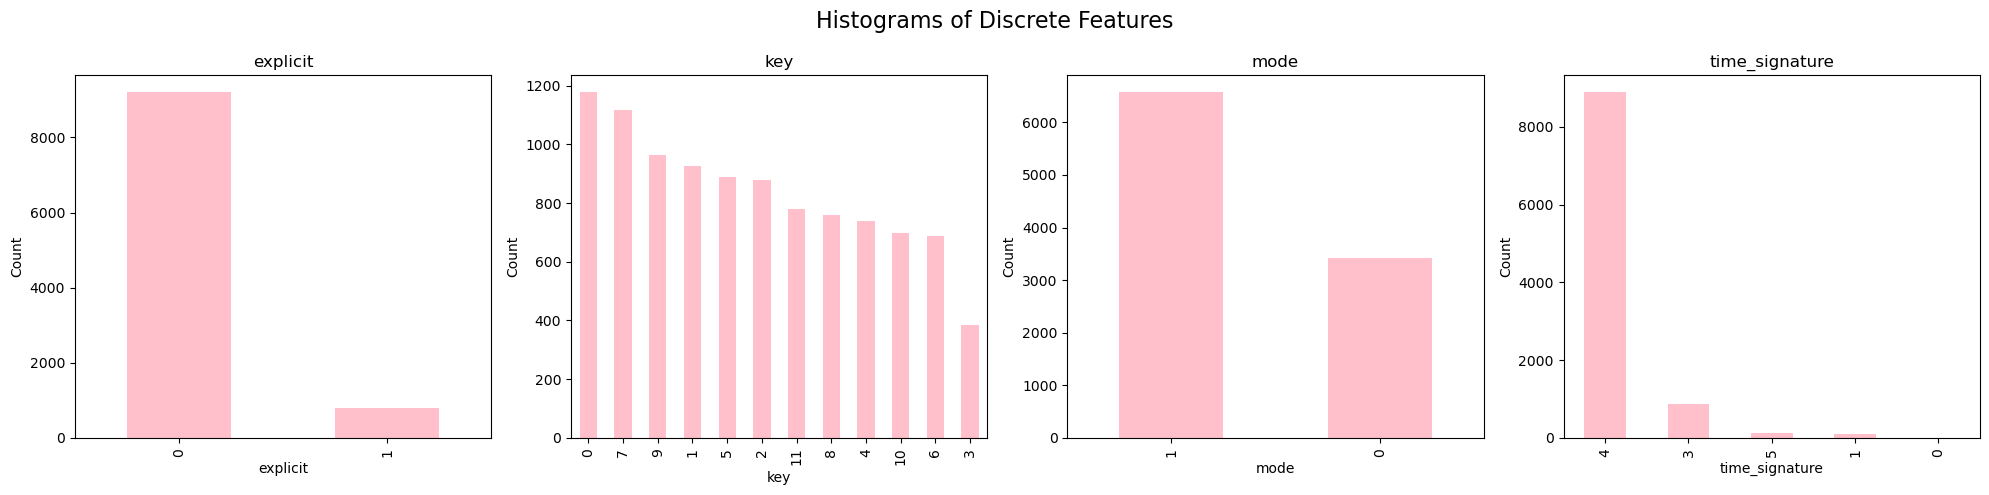

In [7]:
discrete_feature_columns = ['explicit', 'key', 'mode', 'time_signature']

# Set up the matplotlib figure and adjust the size as needed
plt.figure(figsize=(20, 5))

# Loop through each feature column and create a subplot
for i, feature in enumerate(discrete_feature_columns):
    ax = plt.subplot(1, 4, i + 1)  # Create subplot in 1x4 grid configuration
    music_data[feature].value_counts().plot(kind='bar', ax=ax, color='pink')
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('Count')

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top margin to make space for a possible title
plt.suptitle('Histograms of Discrete Features', fontsize=16)
plt.show()

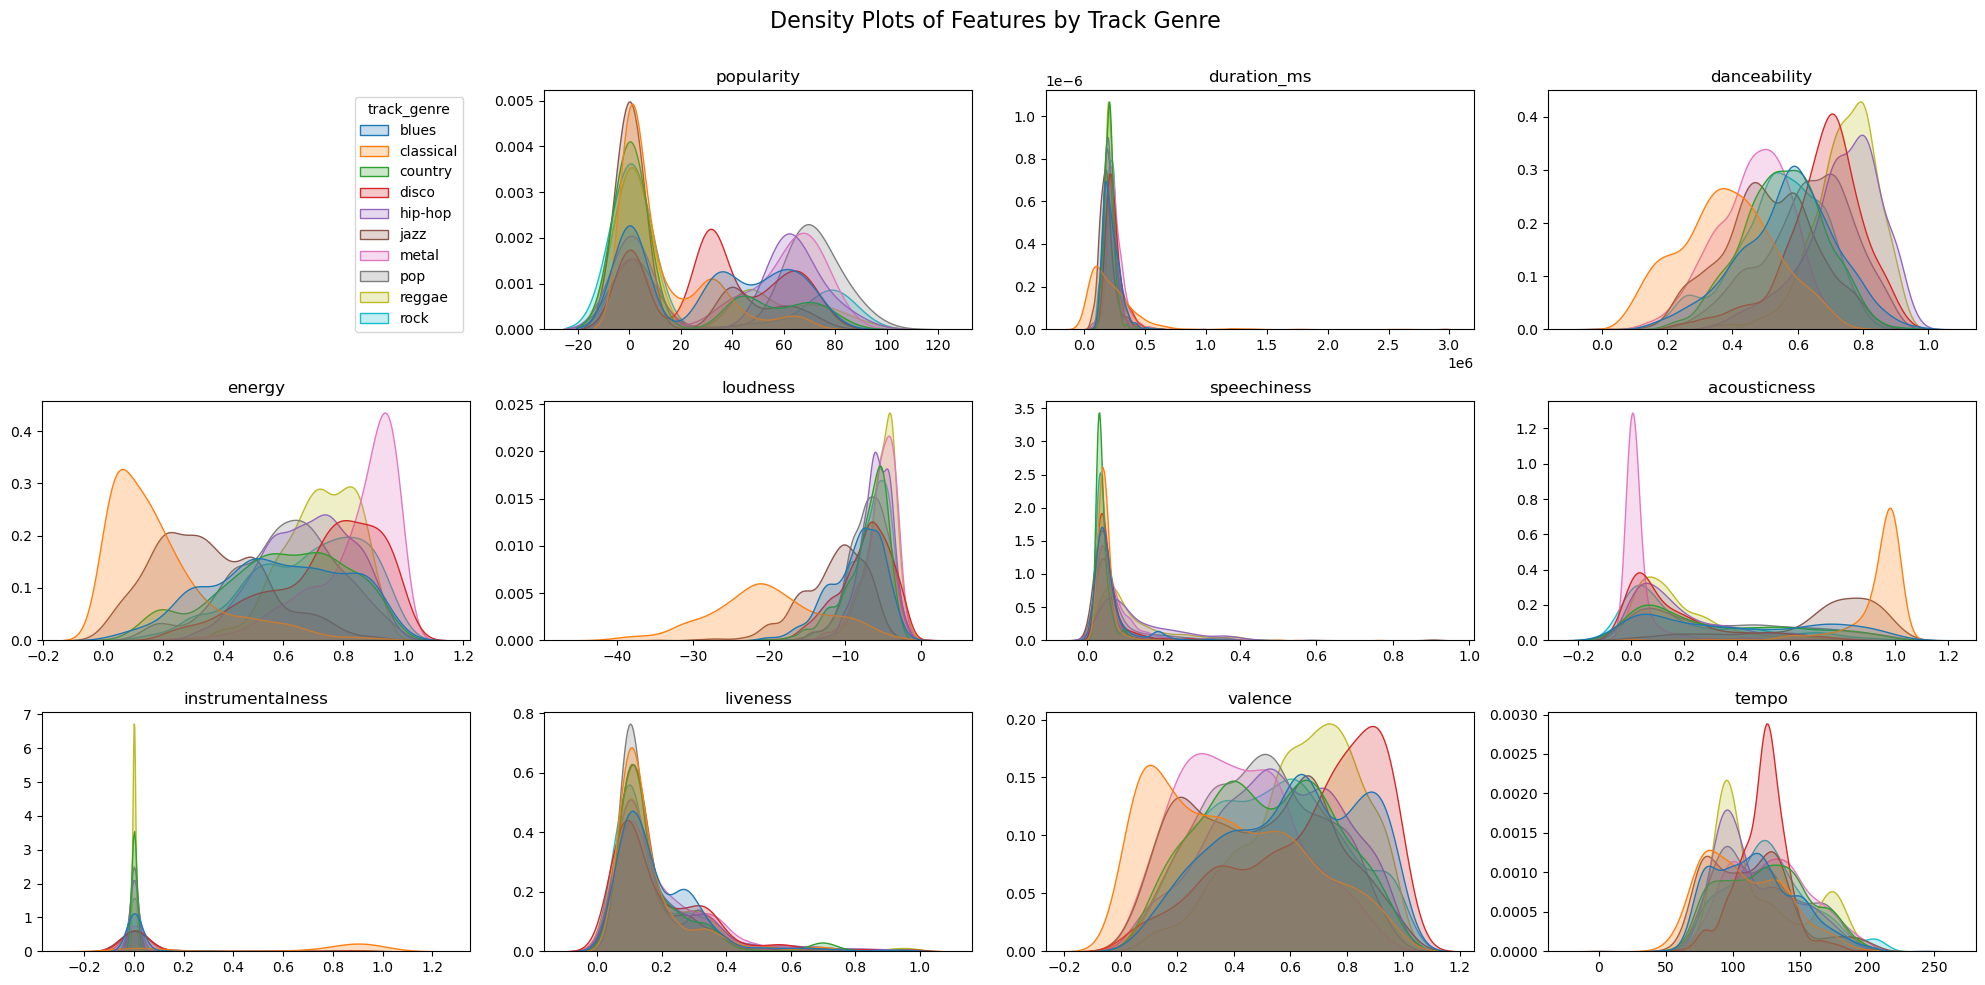

In [8]:
feature_columns = ['popularity', 'duration_ms', 'danceability', 'energy', 
                   'loudness', 'speechiness', 'acousticness', 'instrumentalness',
                   'liveness', 'valence', 'tempo']

# Set up the matplotlib figure and adjust the size as needed
plt.figure(figsize=(20, 10))
plot_index = 2

for feature in feature_columns:
    ax = plt.subplot(3, 4, plot_index)
    sns.kdeplot(data=music_data, x=feature, hue='track_genre', fill=True, ax=ax, legend=False)
    plt.title(feature)
    plt.xlabel('')
    plt.ylabel('')
    # print(ax.get_legend_handles_labels())
    plot_index += 1  # Increment subplot index for each loop iteration

# Add the legend to the first subplot cell
legend_ax = plt.subplot(3, 4, 1)  # This places the legend in the first subplot cell
sns.kdeplot(data=music_data, x=feature_columns[1], hue='track_genre', fill=True, ax=legend_ax, legend=True)
legend_ax.set_xlim((100, 101))    # Cheating
legend_ax.set_ylim((100, 101))    # Cheating
legend_ax.axis('off')  # Turn off the axes for the legend subplot

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top margin to make space for a possible title
plt.suptitle('Density Plots of Features by Track Genre', fontsize=16)
plt.show()

## Model Tuning

For Naive Bayes, the parameters I need to tune are:

- For GaussianNB:

    - var_smoothing: Portion of the largest variance of all features that is added to variances for calculation stability.

    'gnb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]

- For MultinomialNB:force_alpha=True

    - alpha: Additive (Laplace/Lidstone) smoothing parameter (set alpha=0 and force_alpha=True, for no smoothing).

    'mnb__alpha': [0.1, 0.5, 1.0, 5.0, 10.0] or [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]

- For SVC:

    - C: Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

    'svc__C': [0.1, 1, 10, 100],

    - kernel

    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    
    - gamma: hyperparam for rbf, poly and sigmoid.

    'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]

- For RandomForest: bootstrap=True, oob=True

    - n_estimators: Number of trees

    'rf__n_estimators': [100, 200, 300],
    
    - max_depth

    'rf__max_depth': [None, 10, 20, 30],
    
    - min_samples_split: min number of samples required to split an internal node

    'rf__min_samples_split': [2, 5, 10],

    - max_features: number of features considered when splitting

    'rf__max_features': ['auto', 'sqrt', 'log2']

## Mass Tuning!!!

In [9]:
model_tunings = []
gnb_model_tuning = Pipeline(steps=[('preprocessor', MinMaxScaler()),
                                  ('classifier', GaussianNB())])
gnb_model = gnb_model_tuning
gnb_param_grid = {
    'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

mnb_model_tuning = Pipeline(steps=[('preprocessor', MinMaxScaler()),
                                  ('classifier', MultinomialNB())])
mnb_model = mnb_model_tuning
mnb_param_grid = {
    'classifier__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
}

svc_model_tuning = Pipeline(steps=[('preprocessor', MinMaxScaler()),
                                  ('classifier', SVC(probability=True))])
svc_model = svc_model_tuning
svc_param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

dt_model_tuning = Pipeline(steps=[('preprocessor', MinMaxScaler()),
                                  ('classifier', DecisionTreeClassifier())])
dt_model = dt_model_tuning
dt_param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

rf_model_tuning = Pipeline(steps=[('preprocessor', MinMaxScaler()),
                                  ('classifier', RandomForestClassifier())])
rf_model = rf_model_tuning
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}


knn_model_tuning = Pipeline(steps=[('preprocessor', MinMaxScaler()),
                                  ('classifier', KNeighborsClassifier())])
knn_model = knn_model_tuning
knn_param_grid = {
    'classifier__n_neighbors': [10, 50, 100],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

logr_model_tuning = Pipeline(steps=[('preprocessor', MinMaxScaler()),
                                  ('classifier', LogisticRegression())])
logr_model = logr_model_tuning
logr_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['sag', 'saga', 'lbfgs']
}



model_tunings.append(['gnb', gnb_model_tuning, gnb_param_grid,  gnb_model])
model_tunings.append(['mnb', mnb_model_tuning, mnb_param_grid,  mnb_model])
model_tunings.append(['svc', svc_model_tuning, svc_param_grid,  svc_model])
model_tunings.append(['dt', dt_model_tuning, dt_param_grid,  dt_model])
model_tunings.append(['rf', rf_model_tuning, rf_param_grid,  rf_model])
model_tunings.append(['knn', knn_model_tuning, knn_param_grid,  knn_model])
model_tunings.append(['logr', logr_model_tuning, logr_param_grid,  logr_model])

In [10]:
def model_tuning(model_name, model_pipeline, param_grid, X_train, y_train, scoring = 'accuracy'):
    print('\nTuning for ', model_name)
    # Perform grid search
    grid_search = GridSearchCV(model_pipeline, param_grid, scoring=scoring, cv=10, n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)

    # Evaluate the results
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

    # Evaluate on the test set
    best_model = grid_search.best_estimator_
    test_accuracy = best_model.score(X_test, y_test)
    print(f"Test set accuracy: {test_accuracy:.2f}")

    with open(model_name+'.pkl', 'wb') as f:
        pickle.dump(best_model, f)   
        print('Model saved to disk!')

    return best_model

In [11]:
for model in model_tunings:
    model[3] = model_tuning(model[0], model[1], model[2], X_train, y_train)


Tuning for  gnb


Best parameters: {'classifier__var_smoothing': 1e-06}
Best cross-validation score: 0.39
Test set accuracy: 0.38
Model saved to disk!

Tuning for  mnb
Best parameters: {'classifier__alpha': 1e-05}
Best cross-validation score: 0.40
Test set accuracy: 0.40
Model saved to disk!

Tuning for  svc
Best parameters: {'classifier__C': 100, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
Best cross-validation score: 0.60
Test set accuracy: 0.59
Model saved to disk!

Tuning for  dt
Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_split': 2}
Best cross-validation score: 0.54
Test set accuracy: 0.53
Model saved to disk!

Tuning for  rf
Best parameters: {'classifier__max_depth': 30, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation score: 0.66
Test set accuracy: 0.66
Model saved to disk!

Tuning for  knn
Best parameters: {'classi

/Users/trietdoky/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/trietdoky/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Best parameters: {'classifier__C': 10, 'classifier__solver': 'sag'}
Best cross-validation score: 0.49
Test set accuracy: 0.49
Model saved to disk!


## Model Manual Check

Traning error score:  0.941375
Testing error score:  0.658
Classification Report:
               precision    recall  f1-score   support

       blues       0.47      0.43      0.45       214
   classical       0.89      0.93      0.91       189
     country       0.69      0.67      0.68       196
       disco       0.65      0.75      0.70       196
     hip-hop       0.66      0.62      0.64       193
        jazz       0.71      0.64      0.67       226
       metal       0.62      0.78      0.69       196
         pop       0.54      0.62      0.58       192
      reggae       0.67      0.66      0.66       195
        rock       0.71      0.51      0.60       203

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.66      0.66      0.66      2000



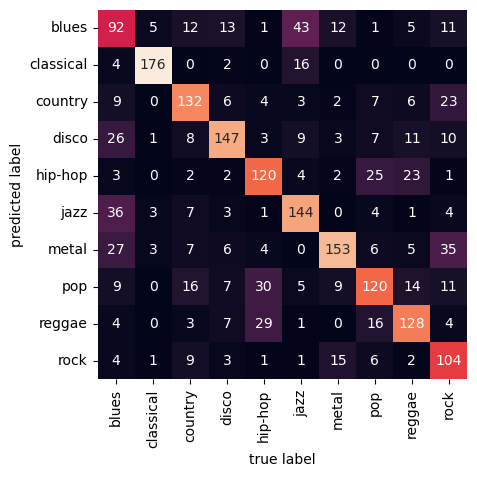

In [21]:
check_model = model_tunings[4][3]
nb_prediction = check_model.predict(X_test)
mat = confusion_matrix(y_test, nb_prediction)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label')
print("Traning error score: ", check_model.score(X_train, y_train))
print("Testing error score: ", check_model.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, nb_prediction))

## Algorithm Evaluation

Train on the whole set.

In [38]:
#evaluate each algorithm
results = []
names = []
for model in model_tunings:
    #If not statified, shuffle is vital given data is ordered by labels.
    kfold = KFold(n_splits=10, shuffle=True, random_state=7)
    cv_results = cross_val_score(model[3], X.to_numpy(), y.to_numpy(), cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(model[0])
    print( "%s: %f (%f)" % (model[0], cv_results.mean(), cv_results.std()))

gnb: 0.387200 (0.015766)
mnb: 0.389900 (0.017991)
svc: 0.599400 (0.007310)
dt: 0.531600 (0.013109)
rf: 0.659400 (0.011386)
knn: 0.591300 (0.009001)
logr: 0.490000 (0.019422)


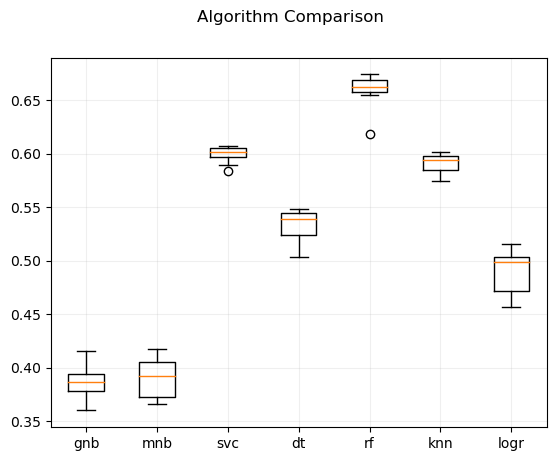

In [35]:
#boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.grid(True, alpha=0.2)
plt.show()

## Random Forest Training

Traning error score:  0.941375
Testing error score:  0.658
Classification Report:
               precision    recall  f1-score   support

       blues       0.47      0.43      0.45       214
   classical       0.89      0.93      0.91       189
     country       0.69      0.67      0.68       196
       disco       0.65      0.75      0.70       196
     hip-hop       0.66      0.62      0.64       193
        jazz       0.71      0.64      0.67       226
       metal       0.62      0.78      0.69       196
         pop       0.54      0.62      0.58       192
      reggae       0.67      0.66      0.66       195
        rock       0.71      0.51      0.60       203

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.66      0.66      0.66      2000



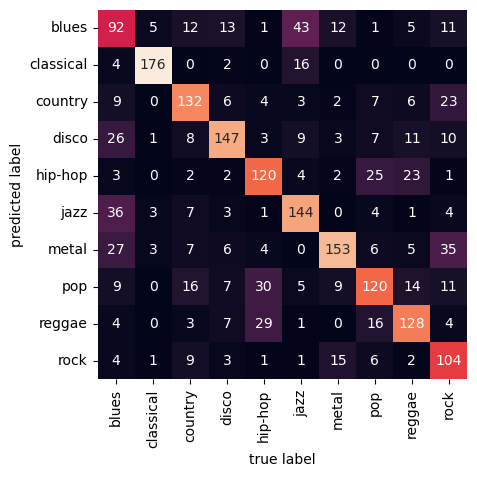

In [29]:
check_model = model_tunings[4][3]
y_prediction = check_model.predict(X_test)
mat = confusion_matrix(y_test, y_prediction)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label')
print("Traning error score: ", check_model.score(X_train, y_train))
print("Testing error score: ", check_model.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_prediction))

## Feature Importance

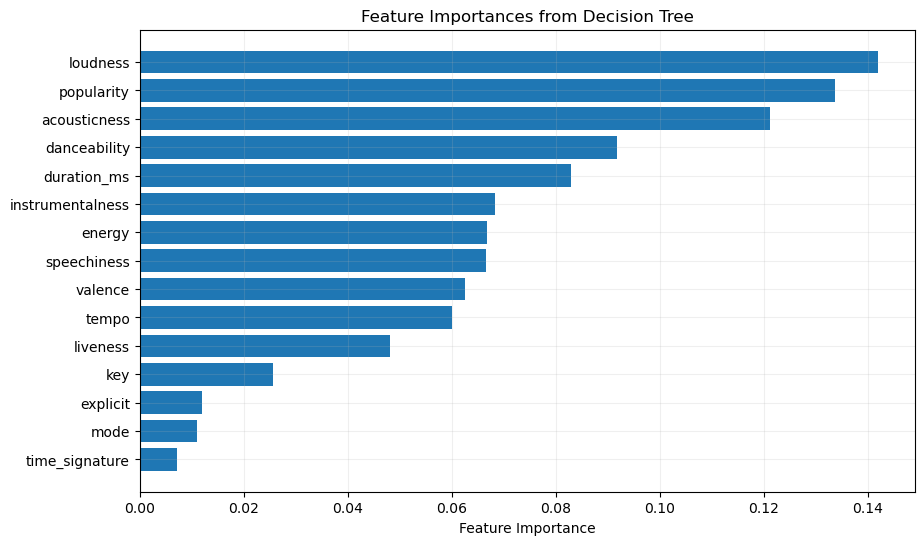

In [39]:
tree_check = DecisionTreeClassifier()
tree_check.fit(X.to_numpy(), y.to_numpy())
fi_data = tree_check.feature_importances_

sorted_i = np.argsort(fi_data)
sorted_importances = fi_data[sorted_i]
sorted_feature_names = [feature_names[idx] for idx in sorted_i]


# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Decision Tree')
plt.grid(True, alpha=0.2)
plt.show()

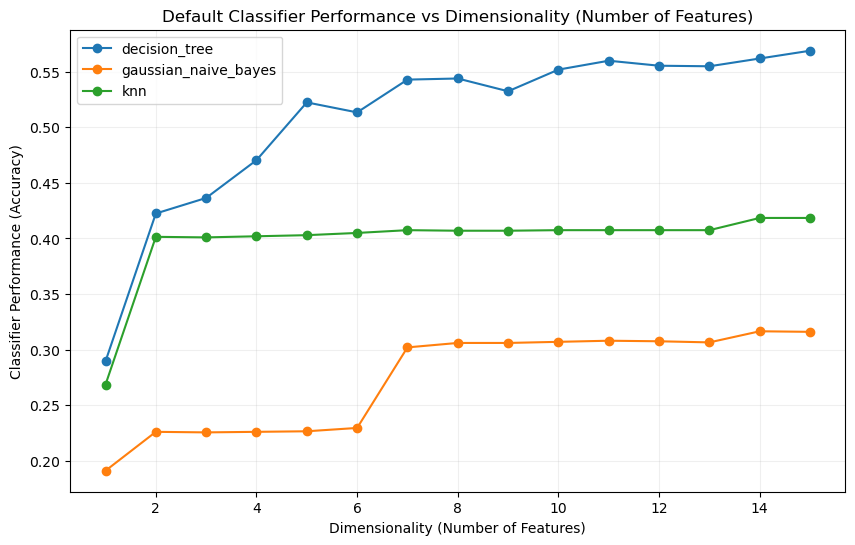

In [36]:
check_model = [['decision_tree', DecisionTreeClassifier()], 
            #    ['random_forest', RandomForestClassifier()], 
               ['gaussian_naive_bayes', GaussianNB()],
               ['knn', KNeighborsClassifier(weights='distance', metric='manhattan', n_neighbors=10)]]
# check_model_1 = DecisionTreeClassifier()
# check_model_2 = GaussianNB()
model_accuracies = {}
for i in range(0, len(check_model)):
    accuracies = []
    for j in range(1, X_train.shape[1] + 1):
        # Select the first i features
        X_train_reduced = X_train[:, :j]
        X_test_reduced = X_test[:, :j]
        
        check_model[i][1].fit(X_train_reduced, y_train)
        
        # Predict on the test set
        predictions = check_model[i][1].predict(X_test_reduced)
        
        # Calculate the accuracy
        accuracy = accuracy_score(y_test, predictions)
        accuracies.append(accuracy)
    model_accuracies[check_model[i][0]] = accuracies

# Creating an index for x-axis
x = range(1, len(model_accuracies['decision_tree']) + 1)

# Plotting the data
plt.figure(figsize=(10, 6))
for key in model_accuracies.keys():
    plt.plot(x, model_accuracies[key], marker='o', label=key)

# Adding titles and labels
plt.title('Default Classifier Performance vs Dimensionality (Number of Features)')
# plt.suptitle('with default model parameters')
plt.xlabel('Dimensionality (Number of Features)')
plt.ylabel('Classifier Performance (Accuracy)')
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()


